In [4]:
import os.path as osp
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
import torch
import torch.nn.functional as F

from tqdm import tqdm

from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv
from torch.nn import Linear
from typing import Tuple, Union

import torch.nn.functional as F
from torch import Tensor
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size
import torch.utils.data as data_utils

import argparse

In [8]:
from torch_geometric.nn.models import DeepGraphInfomax

In [1]:
import wandb

In [2]:
wandb.init(
    project = "pretrain-mlpinit",
    dir = "./wandb",
    config = {
        "init_method": "mlp",
        "dataset_name": "ogbn-arxiv",
        "batch_size": 1024,
        "num_layers": 4,
        "hidden_channels": 512
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kats. Use `wandb login --relogin` to force relogin
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [5]:
dataset_dir = "./data"
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root = osp.join(dataset_dir, wandb.config.dataset_name)

dataset = PygNodePropPredDataset(wandb.config.dataset_name, root)
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name=wandb.config.dataset_name)
data = dataset[0]
train_idx = split_idx["train"]

x_train = data.x[split_idx["train"]]
y_train = data.y[split_idx["train"]].reshape(-1).type(torch.long)


x = data.x
y = data.y.squeeze()


print("data.x.shape:", data.x.shape)
print("data.y.shape:", data.y.shape)
print("data.x.type:", x.dtype)
print("data.y.type:", y.dtype)
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)


y = data.y.squeeze().type(torch.long)


x_y_train_mlpinit = data_utils.TensorDataset(x_train, y_train)
x_y_all_mlpinit = data_utils.TensorDataset(x, y)

train_mlpinit_loader = data_utils.DataLoader(
    x_y_train_mlpinit,
    batch_size=wandb.config.batch_size,
    shuffle=True,
    num_workers=num_workers,
)
all_mlpinit_loader = data_utils.DataLoader(
    x_y_all_mlpinit,
    batch_size=wandb.config.batch_size,
    shuffle=False,
    num_workers=num_workers,
)


class SAGEConv_PeerMLP(torch.nn.Module):
    """
    A PyTorch module implementing a simplified GraphSAGE convolution-like multilayer perceptron (MLP) layer.

    This layer performs a linear transformation on the input node features, optionally normalizing
    the output and adding a root weight.
    """

    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        normalize: bool = False,
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()

    def forward(self, x: Union[Tensor, OptPairTensor]) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        out = x[1]
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2.0, dim=-1)

        return out


class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv_PeerMLP(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv_PeerMLP(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv_PeerMLP(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x):
        for i in range(self.num_layers):
            x_target = x
            x = self.convs[i]((x, x_target))
            if i != self.num_layers - 1:
                x = F.relu(x)
        return x.log_softmax(dim=-1)


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[: size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
        return x.log_softmax(dim=-1)

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description("Evaluating")

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[: size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


model_mlpinit = MLP(
    in_channels=dataset.num_features,
    hidden_channels=wandb.config.hidden_channels,
    out_channels=dataset.num_classes,
    num_layers=wandb.config.num_layers,
)
model_mlpinit = model_mlpinit.to(device)
optimizer_model_mlpinit = torch.optim.Adam(model_mlpinit.parameters(), lr=0.001, weight_decay=0.0)

## теперь нужно посмотреть, тренируется ли эта модель и как. найти где можно организовать графики
## найти как они измеряют и запустить тупо на всём датасете
## всунуть дги везде где можно чтобы проверить на всем чем можно

def train_mlpinit():
    def index_corruption(x):
        mask = torch.ones(x.size()[0], 128)
        mask[:][torch.randperm(128)[:32]] = 0
        mask = mask.to(device)
        x = torch.where(mask.bool(), x, torch.zeros_like(x))
        return x

    def dropout_corruption(x):
        pass

    def summary(z, *args, **kwargs):
        return torch.sigmoid(z.mean(dim=0))

    total_loss = 0

    unsupervised_model = DeepGraphInfomax(hidden_channels=40, encoder=model_mlpinit, summary=summary, corruption=index_corruption)
    unsupervised_model.train()
    for x, _ in tqdm(train_mlpinit_loader):
        x = x.to(device)

        optimizer_model_mlpinit.zero_grad()
        pos_z, neg_z, summary = unsupervised_model(x)
        loss = unsupervised_model.loss(pos_z, neg_z, summary)
        loss.backward()
        optimizer_model_mlpinit.step()

        total_loss += float(loss)

    loss = total_loss / len(train_mlpinit_loader)
    unsupervised_model.eval()
    return loss, 0


@torch.no_grad()
def test_mlpinit():
    model_mlpinit.eval()

    out_list = []
    y_list = []

    for x, y in tqdm(all_mlpinit_loader):
        x = x.to(device)
        y = y.to(device)
        out = model_mlpinit(x)
        out_list.append(out)
        y_list.append(y)

    out = torch.cat(out_list, dim=0)
    y_true = torch.cat(y_list, dim=0).cpu().unsqueeze(-1)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval(
        {
            "y_true": y_true[split_idx["train"]],
            "y_pred": y_pred[split_idx["train"]],
        }
    )["acc"]
    val_acc = evaluator.eval(
        {
            "y_true": y_true[split_idx["valid"]],
            "y_pred": y_pred[split_idx["valid"]],
        }
    )["acc"]
    test_acc = evaluator.eval(
        {
            "y_true": y_true[split_idx["test"]],
            "y_pred": y_pred[split_idx["test"]],
        }
    )["acc"]

    return train_acc, val_acc, test_acc


train_loader = NeighborSampler(
    data.edge_index,
    node_idx=train_idx,
    sizes=[25, 10, 5, 5],
    batch_size=wandb.config.batch_size,
    shuffle=True,
    num_workers=num_workers,
)
subgraph_loader = NeighborSampler(
    data.edge_index,
    node_idx=None,
    sizes=[-1],
    batch_size=wandb.config.batch_size,
    shuffle=False,
    num_workers=num_workers,
)


model = SAGE(
    in_channels=dataset.num_features,
    hidden_channels=wandb.config.hidden_channels,
    out_channels=dataset.num_classes,
    num_layers=wandb.config.num_layers,
)
model = model.to(device)


def train(epoch):
    model.train()

    pbar = tqdm(total=train_idx.size(0))
    pbar.set_description(f"Epoch {epoch:02d}")

    total_loss = total_correct = 0

    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()

        out = model(x[n_id].to(device), adjs)
        loss = F.nll_loss(out, y[n_id[:batch_size]].to(device))
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]].to(device)).sum())
        pbar.update(batch_size)

    pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / train_idx.size(0)

    return loss, approx_acc


@torch.no_grad()
def test():
    model.eval()

    out = model.inference(x)

    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval(
        {
            "y_true": y_true[split_idx["train"]],
            "y_pred": y_pred[split_idx["train"]],
        }
    )["acc"]
    val_acc = evaluator.eval(
        {
            "y_true": y_true[split_idx["valid"]],
            "y_pred": y_pred[split_idx["valid"]],
        }
    )["acc"]
    test_acc = evaluator.eval(
        {
            "y_true": y_true[split_idx["test"]],
            "y_pred": y_pred[split_idx["test"]],
        }
    )["acc"]

    return train_acc, val_acc, test_acc

data.x.shape: torch.Size([169343, 128])
data.y.shape: torch.Size([169343, 1])
data.x.type: torch.float32
data.y.type: torch.int64
x_train.shape: torch.Size([90941, 128])
y_train.shape: torch.Size([90941])


In [6]:
random_losses = []
random_test_accs = []

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0)

best_val_acc = final_test_acc = 0
for epoch in range (1, 6):
    loss, acc = train(epoch)
    train_acc, val_acc, test_acc = test()
    print(f'Epoch {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, 'f'Test: {test_acc:.4f}')
    wandb.log({"loss": loss, "acc": test_acc})
    random_losses.append(loss)
    random_test_accs.append(test_acc)

Evaluating: 100%|██████████| 677372/677372 [00:20<00:00, 32307.99it/s]


Epoch 01, Train: 0.5160, Val: 0.5134, Test: 0.4560


Evaluating: 100%|██████████| 677372/677372 [00:29<00:00, 23066.28it/s]


Epoch 02, Train: 0.5735, Val: 0.5642, Test: 0.5121


Evaluating: 100%|██████████| 677372/677372 [00:19<00:00, 35434.32it/s]


Epoch 03, Train: 0.5994, Val: 0.5846, Test: 0.5242


Evaluating: 100%|██████████| 677372/677372 [00:26<00:00, 25488.82it/s]


Epoch 04, Train: 0.6094, Val: 0.5820, Test: 0.5269


Epoch 05:  28%|██▊       | 25600/90941 [00:42<01:31, 717.76it/s]

KeyboardInterrupt: 

In [9]:
model_mlpinit.reset_parameters()

for epoch in range(1, 6):
    loss, acc = train_mlpinit()
    
torch.save(model_mlpinit.state_dict(), f'./model_mlpinit.pt' )
train_acc_init, val_acc_init, test_acc_init = test_mlpinit()
print("train_acc_init, val_acc_init, test_acc_init:", train_acc_init, val_acc_init, test_acc_init )


100%|██████████| 89/89 [00:20<00:00,  4.43it/s]

100%|██████████| 89/89 [00:19<00:00,  4.64it/s]

100%|██████████| 89/89 [00:18<00:00,  4.76it/s]

100%|██████████| 89/89 [00:17<00:00,  4.96it/s]

100%|██████████| 89/89 [00:18<00:00,  4.87it/s]

100%|██████████| 166/166 [00:06<00:00, 25.50it/s]

train_acc_init, val_acc_init, test_acc_init: 0.0042994908787015755 0.004026980771166817 0.004917391930539267


In [12]:
mlpinit_losses = []
mlpinit_test_accs = []

model.load_state_dict(torch.load( f'./model_mlpinit.pt'  ))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0)

best_val_acc = final_test_acc = 0
for epoch in range(1, 6):
    loss, acc = train(epoch)
    train_acc, val_acc, test_acc = test()
    print(f'Epoch {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, 'f'Test: {test_acc:.4f}')
    wandb.log({"loss": loss, "acc": test_acc})
    mlpinit_losses.append(loss)
    mlpinit_test_accs.append(test_acc)



  0%|          | 0/90941 [00:00<?, ?it/s]

Epoch 01:   0%|          | 0/90941 [00:00<?, ?it/s]

Epoch 01:   1%|          | 1024/90941 [00:01<02:44, 547.82it/s]

Epoch 01:   2%|▏         | 2048/90941 [00:02<02:02, 727.33it/s]

Epoch 01:   3%|▎         | 3072/90941 [00:04<02:18, 632.82it/s]

Epoch 01:   5%|▍         | 4096/90941 [00:06<02:03, 706.03it/s]

Epoch 01:   6%|▌         | 5120/90941 [00:07<02:04, 688.69it/s]

Epoch 01:   7%|▋         | 6144/90941 [00:09<02:01, 695.63it/s]

Epoch 01:   8%|▊         | 7168/90941 [00:10<02:01, 688.16it/s]

Epoch 01:   9%|▉         | 8192/90941 [00:13<02:35, 531.71it/s]

Epoch 01:  10%|█         | 9216/90941 [00:15<02:50, 480.00it/s]

Epoch 01:  11%|█▏        | 10240/90941 [00:18<03:02, 441.51it/s]

Epoch 01:  12%|█▏        | 11264/90941 [00:20<02:55, 453.03it/s]

Epoch 01:  14%|█▎        | 12288/90941 [00:23<03:11, 411.76it/s]

Epoch 01:  15%|█▍        | 13312/90941 [00:25<02:57, 436.81it/s]

Epoch 01:  16%|█▌        | 14336/90941 [00:28<02:57, 

Epoch 01, Train: 0.4934, Val: 0.4954, Test: 0.4397




  0%|          | 0/90941 [00:00<?, ?it/s]

Epoch 02:   0%|          | 0/90941 [00:00<?, ?it/s]

Epoch 02:   1%|          | 1024/90941 [00:04<06:41, 224.14it/s]

Epoch 02:   2%|▏         | 2048/90941 [00:06<04:29, 329.34it/s]

Epoch 02:   3%|▎         | 3072/90941 [00:08<03:40, 397.69it/s]

Epoch 02:   5%|▍         | 4096/90941 [00:10<03:06, 466.80it/s]

Epoch 02:   6%|▌         | 5120/90941 [00:12<02:55, 489.08it/s]

Epoch 02:   7%|▋         | 6144/90941 [00:13<02:41, 523.99it/s]

Epoch 02:   8%|▊         | 7168/90941 [00:15<02:43, 512.47it/s]

Epoch 02:   9%|▉         | 8192/90941 [00:18<02:58, 463.41it/s]

Epoch 02:  10%|█         | 9216/90941 [00:20<02:57, 460.90it/s]

Epoch 02:  11%|█▏        | 10240/90941 [00:22<02:36, 516.36it/s]

Epoch 02:  12%|█▏        | 11264/90941 [00:23<02:26, 543.19it/s]

Epoch 02:  14%|█▎        | 12288/90941 [00:25<02:28, 531.24it/s]

Epoch 02:  15%|█▍        | 13312/90941 [00:27<02:14, 576.17it/s]

Epoch 02:  16%|█▌        | 14336/90941 [00:28<02:04, 

Epoch 02, Train: 0.5672, Val: 0.5475, Test: 0.4870




  0%|          | 0/90941 [00:00<?, ?it/s]

Epoch 03:   0%|          | 0/90941 [00:00<?, ?it/s]

Epoch 03:   1%|          | 1024/90941 [00:02<03:10, 473.24it/s]

Epoch 03:   2%|▏         | 2048/90941 [00:03<02:27, 604.27it/s]

Epoch 03:   3%|▎         | 3072/90941 [00:04<02:06, 694.12it/s]

Epoch 03:   5%|▍         | 4096/90941 [00:06<02:08, 673.89it/s]

Epoch 03:   6%|▌         | 5120/90941 [00:07<02:07, 673.69it/s]

Epoch 03:   7%|▋         | 6144/90941 [00:09<02:15, 624.48it/s]

Epoch 03:   8%|▊         | 7168/90941 [00:10<02:03, 676.71it/s]

Epoch 03:   9%|▉         | 8192/90941 [00:12<02:08, 642.63it/s]

Epoch 03:  10%|█         | 9216/90941 [00:14<02:12, 617.75it/s]

Epoch 03:  11%|█▏        | 10240/90941 [00:16<02:10, 619.90it/s]

Epoch 03:  12%|█▏        | 11264/90941 [00:17<02:03, 646.55it/s]

Epoch 03:  14%|█▎        | 12288/90941 [00:19<02:02, 640.60it/s]

Epoch 03:  15%|█▍        | 13312/90941 [00:21<02:08, 605.36it/s]

Epoch 03:  16%|█▌        | 14336/90941 [00:23<02:12, 

Epoch 03, Train: 0.5891, Val: 0.5678, Test: 0.5119




  0%|          | 0/90941 [00:00<?, ?it/s]

Epoch 04:   0%|          | 0/90941 [00:00<?, ?it/s]

Epoch 04:   1%|          | 1024/90941 [00:02<02:57, 507.53it/s]

Epoch 04:   2%|▏         | 2048/90941 [00:03<02:14, 660.51it/s]

Epoch 04:   3%|▎         | 3072/90941 [00:04<01:57, 746.50it/s]

Epoch 04:   5%|▍         | 4096/90941 [00:06<02:28, 584.88it/s]

Epoch 04:   6%|▌         | 5120/90941 [00:08<02:38, 540.28it/s]

Epoch 04:   7%|▋         | 6144/90941 [00:10<02:39, 533.12it/s]

Epoch 04:   8%|▊         | 7168/90941 [00:12<02:32, 548.37it/s]

Epoch 04:   9%|▉         | 8192/90941 [00:13<02:13, 618.56it/s]

KeyboardInterrupt: 

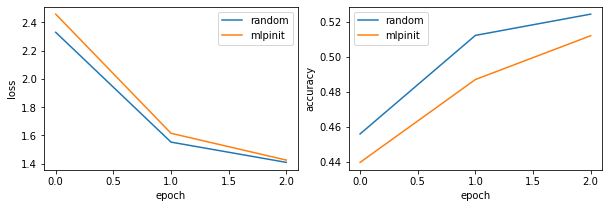

In [23]:
import matplotlib.pyplot as plt

x=range( 0, 3 )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, random_losses[:3], label='random')
ax1.plot(x, mlpinit_losses, label='mlpinit')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()


ax2.plot(x, random_test_accs[:3], label='random')
ax2.plot(x, mlpinit_test_accs, label='mlpinit')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

plt.show()

In [24]:
import numpy as np

In [80]:
def find_best_speedup(random_accs, mlpinit_accs):
    best_speedup = 0
    best_line = 0
    for value in np.linspace(start=0, stop=1, num=10):
        first_achieved = 0
        second_achieved = 1000
        for j in range(len(random_accs)):
            if random_accs[j] > value:
                first_achieved = j
                break
        first_achieved += 1
        for j in range(len(mlpinit_accs)):
            if mlpinit_accs[j] > value:
                second_achieved = j
                break
        second_achieved += 1
        if second_achieved == 0:
            best_speedup = 0
        else:
            if best_speedup < first_achieved/second_achieved:
                best_line = value
                best_speedup = first_achieved/second_achieved
    return best_line, best_speedup

In [81]:
best_line, best_speedup = find_best_speedup(random_test_accs[:3], mlpinit_test_accs)

In [84]:
best_line, best_speedup = find_best_speedup(a1, a2)

In [85]:
my_table = wandb.Table(columns=["best_line", "best_speedup"], data=[[best_line, best_speedup]])

In [86]:
wandb.log({"table": my_table})

In [78]:
a1 = [0.1, 0.2, 0.4]
a2 = [0.4, 0.4, 0.4]